In [2]:
import glob
import numpy as np
from MDAnalysis.analysis import rms

## Straight RMSD

In [21]:
def read_first_mol(i=1):
    molname = f"conformers/mol{i:04d}"
    rdname = f"{molname}*_rd.npy"
    oename = f"{molname}*_oe.npy"
    
    rdconfs = []
    oeconfs = []
    
    for file in sorted(glob.glob(rdname)):
        rdconf = np.load(file)
        rdconfs.append(rdconf[0])
        
    for file in sorted(glob.glob(oename)):
        oeconf = np.load(file)
        oeconfs.append(oeconf[0])
        
    toolkits = ["RDKit"] * len(rdconfs) + ["OpenEye"] * len(oeconfs)
        
    confs = np.concatenate([rdconfs, oeconfs])
    
    rmsds = np.zeros((len(confs), len(confs)))
    for i, iconf in enumerate(confs):
        for j, jconf in enumerate(confs[i + 1:], i + 1):
            rmsds[i, j] = rmsds[j, i] = rms.rmsd(iconf, jconf, superposition=True)
    return rmsds, toolkits

In [17]:
def read_mol(i=1):
    molname = f"conformers/mol{i:04d}"
    rdname = f"{molname}*_rd.npy"
    oename = f"{molname}*_oe.npy"
    
    rdconfs = []
    oeconfs = []
    orders = []
    
    for file in sorted(glob.glob(rdname)):
        rdconf = np.load(file)
        rdconfs.append(rdconf)
        i = int(file.split("_m")[1].split("_")[0])
        orders.extend([i] * len(rdconf))
        
    toolkits = ["RDKit"] * len(orders)
        
    for file in sorted(glob.glob(oename)):
        oeconf = np.load(file)
        oeconfs.append(oeconf)
        i = int(file.split("_m")[1].split("_")[0])
        orders.extend([i] * len(oeconf))
        toolkits.extend(["OpenEye"] * len(oeconf))
        
    all_rdconfs = np.concatenate(rdconfs)
    all_oeconfs = np.concatenate(oeconfs)
    confs = np.concatenate([all_rdconfs, all_oeconfs])
    
    rmsds = np.zeros((len(confs), len(confs)))
    for i, iconf in enumerate(confs):
        for j, jconf in enumerate(confs[i + 1:], i + 1):
            rmsds[i, j] = rmsds[j, i] = rms.rmsd(iconf, jconf, superposition=True)
    return rmsds, orders, toolkits

In [18]:
rmsd_1, orders_1, toolkits_1 = read_mol()

In [22]:
frmsd_1, ftoolkits_1 = read_first_mol(1)

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [32]:
xi, xj = np.where(np.array(ftoolkits_1) == "RDKit")[0][[0, -1]]

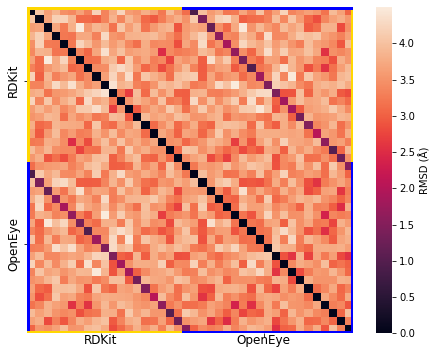

In [76]:
# fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(frmsd_1, ax=ax, square=True, cbar_kws={"label": "RMSD (Å)"})
XJ = len(frmsd_1)
tickrange = [int((xj - xi)/2), int(xj + (XJ - xj)/2)]
ax.set_yticks(tickrange)
ax.set_xticks(tickrange)
ax.set_yticklabels(["RDKit", "OpenEye"], fontsize=12, va="center")
ax.set_xticklabels(["RDKit", "OpenEye"], fontsize=12, va="center")
ax.vlines(x=-0.2, ymin=xi, ymax=xj, lw=8, color="gold")
ax.vlines(x=-0.2, ymin=xj, ymax=XJ, lw=8, color="blue")
ax.vlines(x=XJ+0.2, ymin=xi, ymax=xj, lw=8, color="gold")
ax.vlines(x=XJ+0.2, ymin=xj, ymax=XJ, lw=8, color="blue")
ax.hlines(y=-0.2, xmin=xi, xmax=xj, lw=8, color="gold")
ax.hlines(y=-0.2, xmin=xj, xmax=XJ, lw=8, color="blue")
ax.hlines(y=XJ+0.2, xmin=xi, xmax=xj, lw=8, color="gold")
ax.hlines(y=XJ+0.2, xmin=xj, xmax=XJ, lw=8, color="blue")

# plt.tight_layout()
# plt.savefig("compare_first_conformer_rd_vs_oe_mol1.png", dpi=300)

In [77]:
from openff.toolkit.topology import Molecule

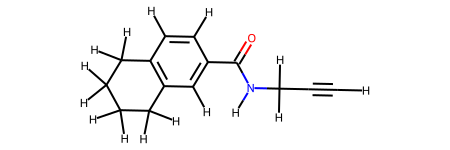

In [78]:
Molecule.from_smiles("C#CCNC(=O)c1ccc2c(c1)CCCC2")

## Internal RMSDS

In [79]:
import numpy as np
import openeye.oechem as oechem
import pandas
from geometric.internal import (
    Angle,
    Dihedral,
    Distance,
    OutOfPlane,
    PrimitiveInternalCoordinates,
)
from geometric.molecule import Molecule as GeometricMolecule
from openff.toolkit.topology import Molecule
from rdkit.Chem import TorsionFingerprints
from simtk import unit

# Define the RMSD calculation parameters
RMSD_AUTOMORPH = True  # take into acct symmetry related transformations
RMSD_HEAVY_ONLY = False  # do consider hydrogen atoms for automorphisms
RMSD_OVERLAY = True  # find the lowest possible RMSD


def _compute_internal_coordinate_rmsd(
    molecule: Molecule,
    qm_conformer: unit.Quantity,
    mm_conformer: unit.Quantity,
) -> Dict[str, float]:

    qm_conformer = qm_conformer.value_in_unit(unit.angstrom)
    mm_conformer = mm_conformer.value_in_unit(unit.angstrom)

    geo_molecule = GeometricMolecule()
    geo_molecule.Data = {
        "resname": ["UNK"] * molecule.n_atoms,
        "resid": [0] * molecule.n_atoms,
        "elem": [atom.element.symbol for atom in molecule.atoms],
        "bonds": [(bond.atom1_index, bond.atom2_index) for bond in molecule.bonds],
        "name": molecule.name,
        "xyzs": [qm_conformer, mm_conformer],
    }

    internal_coordinate_generator = PrimitiveInternalCoordinates(geo_molecule)

    internal_coordinate_types = {
        "Bond": Distance,
        "Angle": Angle,
        "Dihedral": Dihedral,
        "Improper": OutOfPlane,
    }

    internal_coordinates = {
        label: [
            (
                internal_coordinate.value(qm_conformer),
                internal_coordinate.value(mm_conformer),
            )
            for internal_coordinate in internal_coordinate_generator.Internals
            if isinstance(internal_coordinate, internal_coordinate_class)
        ]
        for label, internal_coordinate_class in internal_coordinate_types.items()
    }

    internal_coordinate_rmsd = {}

    for ic_type, ic_values in internal_coordinates.items():

        if len(ic_values) == 0:
            continue

        qm_values, mm_values = zip(*ic_values)

        qm_values = np.array(qm_values)
        mm_values = np.array(mm_values)

        delta = qm_values - mm_values

        rmsd = np.sqrt((delta * delta).mean())
        internal_coordinate_rmsd[ic_type] = float(rmsd)

    return internal_coordinate_rmsd


NameError: name 'Dict' is not defined